In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42)  


In [21]:
layer_num=3
hidden_num=64
sym='symetry'

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [22]:
def potential(x,k):
    poten=1/2*k*x**2
    return poten

In [23]:
def energy(en_level,k,m,h_bar,device,dtype):
    omega=np.sqrt(k/m)
    en_list=[h_bar*omega*(1/2+i) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [24]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)

La=-10
Lb =10
L=Lb-La  # domain length
N = 500   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0

k=4
en_num=50
epoch=3000
lr=0.01
real_en=energy(en_num,k,m,h_bar,device,dtype)

model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=20,threshold=1e-4)
loss_fn=nn.L1Loss()
# Construct the tridiagonal matrix A
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,k)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
print('initial eigenvalues check:')
print(eigenvalues[:en_num])


initial eigenvalues check:
tensor([ 0.9999,  2.9993,  4.9979,  6.9957,  8.9927, 10.9889, 12.9842, 14.9789,
        16.9726, 18.9657, 20.9578, 22.9493, 24.9396, 26.9298, 28.9186, 30.9070,
        32.8944, 34.8810, 36.8667, 38.8520, 40.8363, 42.8194, 44.8018, 46.7836,
        48.7647, 50.7447, 52.7242, 54.7024, 56.6802, 58.6575, 60.6338, 62.6087,
        64.5831, 66.5566, 68.5296, 70.5016, 72.4728, 74.4432, 76.4129, 78.3814,
        80.3496, 82.3163, 84.2830, 86.2485, 88.2137, 90.1772, 92.1400, 94.1020,
        96.0644, 98.0254], device='cuda:0')


In [25]:

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    print('\nepoch:',i)
    print(eigenvalues[:en_num])
    print(real_en)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para_{sym}_{layer_num}_{hidden_num}_{dtype}/model_para_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')



epoch: 0
tensor([-3.7499e-01, -3.7489e-01, -1.3134e-01, -1.1735e-01,  2.9508e-02,
         1.3937e-01,  2.9078e-01,  4.7469e-01,  6.7848e-01,  9.1232e-01,
         1.1686e+00,  1.4514e+00,  1.7584e+00,  2.0904e+00,  2.4471e+00,
         2.8285e+00,  3.2346e+00,  3.6651e+00,  4.1204e+00,  4.6001e+00,
         5.1044e+00,  5.6331e+00,  6.1864e+00,  6.7640e+00,  7.3661e+00,
         7.9926e+00,  8.6434e+00,  9.3185e+00,  1.0018e+01,  1.0742e+01,
         1.1490e+01,  1.2262e+01,  1.3058e+01,  1.3879e+01,  1.4724e+01,
         1.5592e+01,  1.6485e+01,  1.7402e+01,  1.8343e+01,  1.9308e+01,
         2.0296e+01,  2.1309e+01,  2.2345e+01,  2.3405e+01,  2.4489e+01,
         2.5597e+01,  2.6728e+01,  2.7883e+01,  2.9062e+01,  3.0264e+01],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25., 27.,
        29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51., 53., 55.,
        57., 59., 61., 63., 65., 67., 69., 71., 73., 

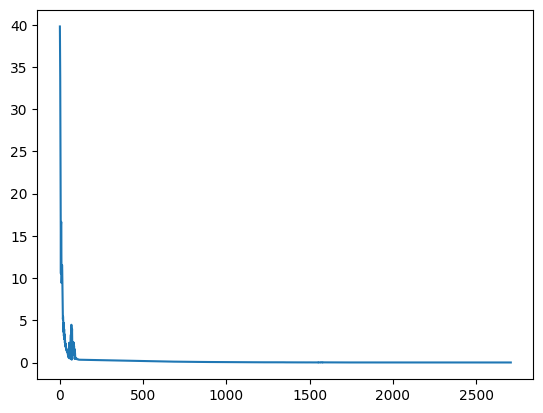

In [26]:
plt.plot(loss_list)
plt.show()

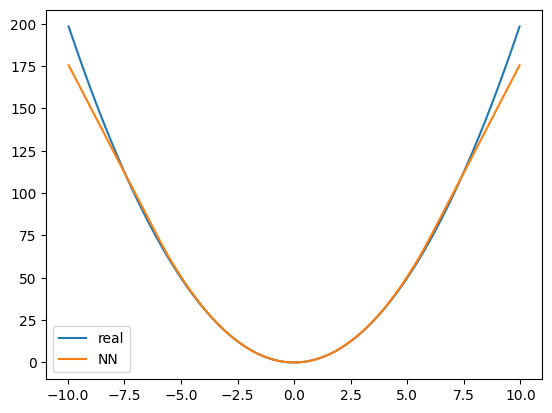

In [27]:

V_NN=model(grid)

os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid.cpu().detach().numpy(),k)
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [28]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 2.794975
max_error: 22.899002
